## 1) PACKAGES AND LIBRARIES INSTALLATION 
(TO DO: explain why we need each package)

In [1]:
!pip install 'plotnine[all]'
!pip install wordcloud
!pip install spacy
!python -m spacy download en
!pip install -U textblob
!python -m textblob.download_corpora
!pip install vaderSentiment

     |████████████████████████████████| 9.2MB 9.7MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/c

In [0]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import re
from spacy.lang.en import English
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from nltk import ngrams
import itertools

## 2) DATABASE
`tweets` is our **main dataset**, the other ones are not used by the moment.

In [0]:
# The dataset from Kaggle:
tweets = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/Tweets.csv")
AAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/AAL.csv")
DAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/DAL.csv")
LUV = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/LUV.csv")
UAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/UAL.csv")
# TO DO: Add the followers and verified

In [4]:
# Dataframe tweets shape
print(tweets.shape)

# Data types
print(tweets.dtypes)

(12265, 18)
Unnamed: 0                        int64
tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
Followers                         int64
Verified                           bool
dtype: object


## 3) DATA CLEANING
*May be we can include here the data cleaning from Machine Learning section*

In [0]:
# Drop the columns we don't use
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'user_timezone'])

# Converting tweet_created to datetime
tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])

## 4) EXPLORATORY DATA ANALYSIS

### 4.1) Sentiment Analysis by Airline
We want to visualize the **distribution sentiment analysis by company**.


The most common class is negative mood = 63.66%


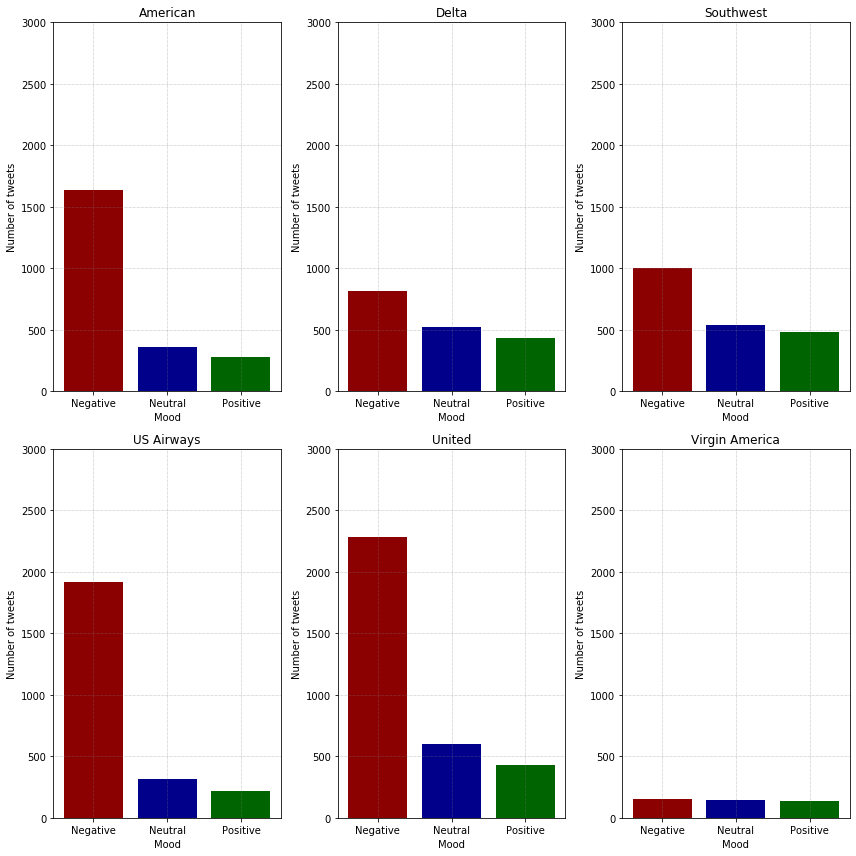

In [6]:
def sentiment_by_airline(Airline):
  df=tweets[tweets['airline']==Airline]
  count=df['airline_sentiment'].value_counts()
  Index = [1,2,3]
  plt.bar(Index,count,color=['darkred', 'darkblue', 'darkgreen'])
  plt.xticks(Index,['Negative','Neutral','Positive'])
  plt.ylabel('Number of tweets')
  plt.xlabel('Mood')
  plt.title(Airline)
  plt.ylim(0,3000)
  plt.grid(which='major', linestyle=':', linewidth='0.5', color='grey')

airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))


for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  sentiment_by_airline(airline)
plt.tight_layout()

count=tweets['airline_sentiment'].value_counts()
print("The most common class is negative mood = "+"{:.2%}".format(count[0]/sum(count[0:3])))


### 4.2) Negative Reason by Airline
In the previous graph we saw that the most common class was the *Negative mood*. Now we want to visualize the **negative ratings clustered on topics**.

The 3 main negative topics of American are: (1) Customer Service Issue, (2) Cancelled Flight and (3) Late Flight
The 3 main negative topics of Delta are: (1) Late Flight, (2) Customer Service Issue and (3) Can't Tell
The 3 main negative topics of Southwest are: (1) Customer Service Issue, (2) Cancelled Flight and (3) Can't Tell
The 3 main negative topics of US Airways are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of United are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of Virgin America are: (1) Customer Service Issue, (2) Flight Booking Problems and (3) Cancelled Flight


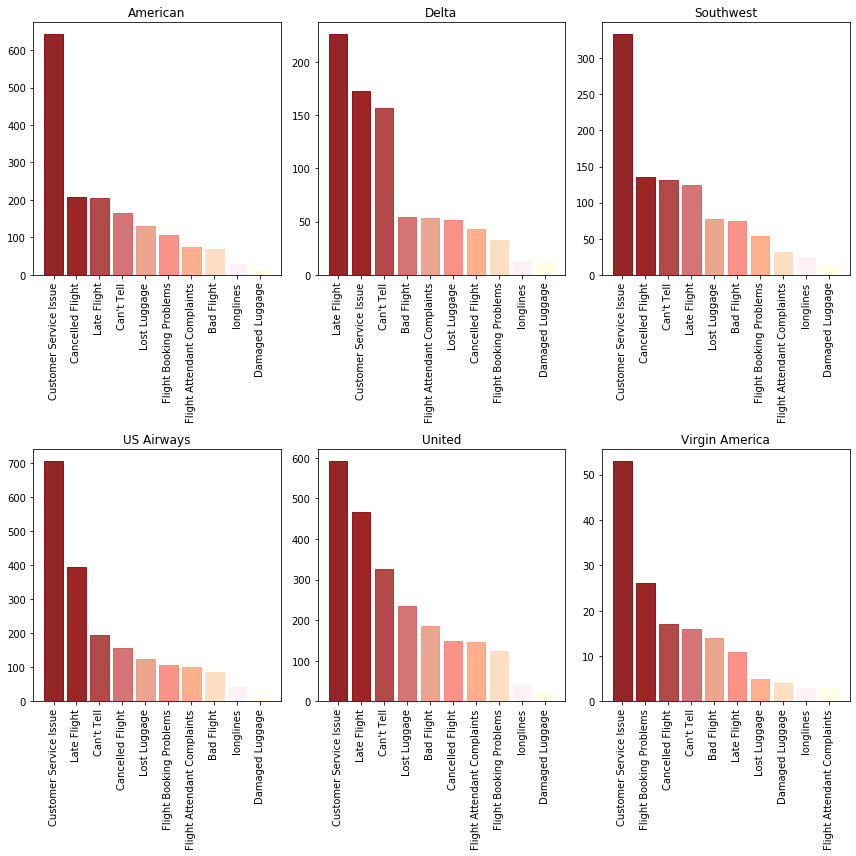

In [7]:
cmap = ['maroon', 'darkred', 'brown', 'indianred', 'darksalmon', 'salmon', 'lightsalmon', 'peachpuff', 'lavenderblush', 'lightyellow']
def negative_reason(Airline):
  df=tweets[tweets['airline']== Airline]
  Neg_reasons_values = df['negativereason'].value_counts(sort=True)
  Neg_reasons_labels = dict(df['negativereason'].value_counts(sort=True))
  Index = range(len(Neg_reasons_values))
  barplot = plt.bar(Index,Neg_reasons_values, alpha = 0.85)
  
  plt.xticks(Index,Neg_reasons_labels, rotation = 90)
  plt.title(Airline)

  for color in cmap:
    barplot[cmap.index(color)].set_color(color)
  
  return ("The 3 main negative topics of " + Airline + " are: (1) " + list(Neg_reasons_labels.keys())[0] + 
  ", (2) " + list(Neg_reasons_labels.keys())[1] + " and (3) " + list(Neg_reasons_labels.keys())[2])


airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))

for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  print(negative_reason(airline))

plt.tight_layout()



### 4.3) Tweet volum per day


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

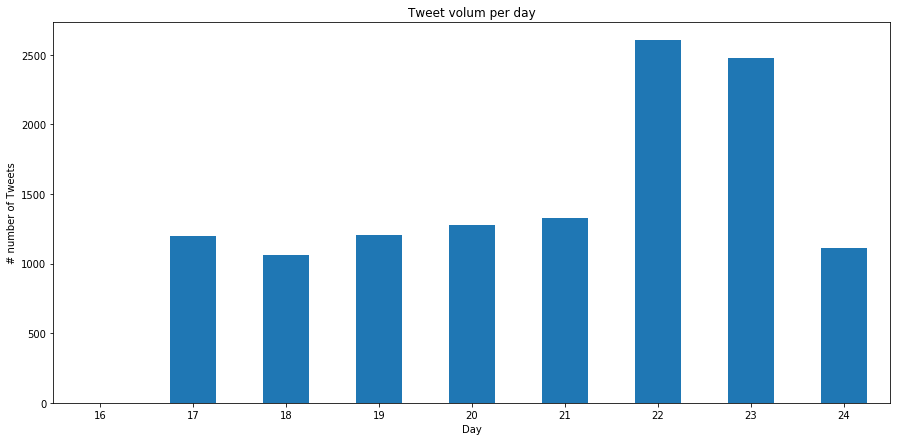

In [8]:
X = tweets['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day]).count().plot(kind="bar")
ax.set_title('Tweet volum per day')
ax.set_ylabel("# number of Tweets")
ax.set_xlabel("Day")
plt.xticks(rotation = 0)


### 4.4) Tweet volum per hour and per day


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, '# number of Tweets')

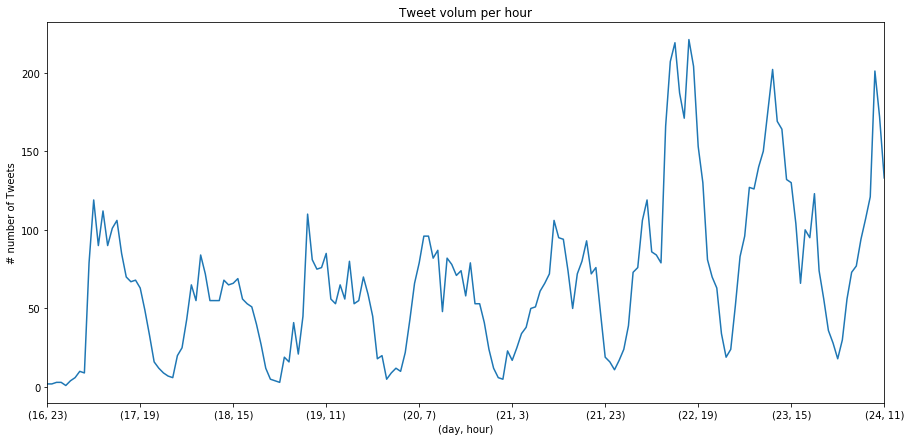

In [9]:
df = tweets[['tweet_created', 'airline_sentiment_confidence']]
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
X = df['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day,X.dt.hour]).count().plot(ax=ax)
ax.set_title('Tweet volum per hour')
ax.set_xlabel("(day, hour)")
ax.set_ylabel("# number of Tweets")


### 4.5) Stock market
*NOT IMPLEMENTED YET*

In [10]:
# Preparing the dataset
"""X_AAL = pd.to_datetime(AAL["Date"])
y_AAL = (AAL["Low"] + AAL["High"])/2
X_DAL = DAL["Date"]
y_DAL = (DAL["Low"] + DAL["High"])/2

# Initialize the data
data = pd.DataFrame(data={'Date': X_AAL, 'Avg Price': y_AAL})

# Create an lineplot
plt.figure(figsize=(15,7))
sns.lineplot(x="Date", y="Avg Price", data=data)
plt.title("American Airlines (AAL)")
plt.show()"""

'X_AAL = pd.to_datetime(AAL["Date"])\ny_AAL = (AAL["Low"] + AAL["High"])/2\nX_DAL = DAL["Date"]\ny_DAL = (DAL["Low"] + DAL["High"])/2\n\n# Initialize the data\ndata = pd.DataFrame(data={\'Date\': X_AAL, \'Avg Price\': y_AAL})\n\n# Create an lineplot\nplt.figure(figsize=(15,7))\nsns.lineplot(x="Date", y="Avg Price", data=data)\nplt.title("American Airlines (AAL)")\nplt.show()'

#### 4.6) Web scraping data
The idea here is to increase our data set. We consider relevant to add the **total amount of followers** and if the **account is verified** or not.

Find below a small sample. We well upload another file with all this the data asap.

In [11]:
from bs4 import BeautifulSoup
import requests

accounts = ('jnardino', 'cairdin', 'yvonnalynn')

for account in accounts:
    url = 'https://www.twitter.com/' + account
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")

    f = soup.find('li', class_="ProfileNav-item--followers")
    title = f.find('a')['title']
    print(list((title, account)))

['7,715 Followers', 'jnardino']
['517 Followers', 'cairdin']
['1,824 Followers', 'yvonnalynn']


### 4.7) World cloud

#### 4.7.1) Draw wordcloud function

The **`draw_wordcloud`** function allows to plot the drawcloud according the sentiment analysis:

**Arguments**: 
*   `sentiment`: string string representing the sentiment. The possible values are: `('positive', 'negative', 'neutral')`. 

In [0]:
def draw_wordcloud(sentiment):
    sentiment_tweets  =tweets[tweets['airline_sentiment']== sentiment]
    words = ' '.join(sentiment_tweets['text'])
    cleaned_word = " ".join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000, height=2500).generate(cleaned_word)
    plt.figure(1,figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [0]:
# draw_wordcloud('negative')

In [0]:
# draw_wordcloud('positive')

In [0]:
# draw_wordcloud('neutral')

## 5) DATA MINING AND MACHINE LEARNING

### 5.1) Tweet sentiment analysis

The function **`tweet_sentiment_analysis`** computes the sentiment analysis of each tweet using **TextBlob** (`polarity` and `subjectivity`) and using **Valder** (`neg`, `neu`, `pos` and `compound`)

The idea is to sort the bunch of tweets based on the polarity/compound level of the tweet *(NOT IMPLEMENTED)*

> **Polarity** : Polarity is a float value within the range `[-1.0 to 1.0]` where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

> **Subjectivity**: Subjectivity is a float value within the range `[0.0 to 1.0]` where 0.0 is very objective and 1.0 is very subjective. 

> **Compound**: Similar to polarity in Textblob, is a float value within the range `[0.0 to 1.0]` where 0.0 is very objective and 1.0 is very subjective. A key difference however, is that Vader was designed with a focus on social media texts. 

In [0]:
def sentiment_analysis(tweet_to_be_classified): #here we use unfiltered tweets because TextBlob and Valder filters them 
    list_sentiments_textblob = []
    list_sentiments_valder = []
    valder = SentimentIntensityAnalyzer()

    for element in tweet_to_be_classified:
        # TextBlob
        # TO DO: correct spelling 
        list_sentiments_textblob.append(TextBlob(element).sentiment)
        # Valder
        list_sentiments_valder.append(valder.polarity_scores(element))

    df = pd.concat([pd.DataFrame(list_sentiments_valder), pd.DataFrame(list_sentiments_textblob)], axis=1, sort=False)

    return df

Here the idea is to detect the language of the tweet (some of them are not in english) -> Then we want to remove it.


In [0]:
def tweet_language(tweets): # Not implemented
    tweets_tokenized = filter_tweets(tweets)
    tweets_language = []

    for token in tweets_tokenized:
      print(TextBlob(token[0]).detect_language()) # TO DO: put more words token[0:3]

In [0]:
# print(tweet_language(tweets["text"][10:20]))
# print(filter_tweets(tweets["text"][10:20]))

In [0]:
# Applying the formula defined in the before code chunk in the whole dataset tweets.
sentiment_table = sentiment_analysis(tweets["text"])

In [0]:
# Storing the sentiment analysis in the dataframe tweets
tweets["polarity_Valder"] = sentiment_table["compound"]
tweets["polarity_Textblob"] = sentiment_table["polarity"]

#### **TextBlob and Valder conversion**
Now we are going to convert the sentiment data we found into strings.
Such that:
> **Polarity ϵ {-1, 1}**
* `-1 <= polarity < 0`: the tweet is negative <br>
* `polarity = 0`: the tweet is neutral <br>
* `0 < polarity <= 1`: the tweet is positive <br>

$$ Where \ p \in (-1, 1)$$


$$
T(p) = \left\{
        \begin{array}{ll}
            negative & if \quad p < 0 \\
            neutral & if \quad p = 0 \\
            positive & if \quad p > 0 \\
        \end{array}
    \right.
$$

**Note**: The values that enable to classify among sentiments are subjective and can be changed.

In [0]:
def polarity_string_conversion(polarity_values, new_column_name):
  polarity_string=[]

  for element in polarity_values:
    if -1 <= element < 0:
      polarity_string.append("negative")
    elif element == 0:
      polarity_string.append("neutral")
    else: 
      polarity_string.append("positive")

  #Adding the string conversion to tweets dataframe
  tweets[new_column_name] = polarity_string

In [22]:
# Computing the conversion and storig to tweets
polarity_string_conversion(tweets["polarity_Textblob"], "polarity_Textblob_string")
polarity_string_conversion(tweets["polarity_Valder"], "polarity_Valder_string")
print(tweets.head(5))

   Unnamed: 0  ...  polarity_Valder_string
0           0  ...                 neutral
1           1  ...                 neutral
2           2  ...                negative
3           3  ...                negative
4           4  ...                negative

[5 rows x 18 columns]


In [0]:
# Preparing the data to be compared with the original classification sentiment
def classification_sentiment(method_used):
  number_equal_sentiment = 0
  for i in range(len(tweets["airline_sentiment"])):
    if tweets["airline_sentiment"][i] == tweets["polarity_"+ method_used +"_string"][i]:
        number_equal_sentiment += 1
  return ("Using the method "+ method_used + ": We estimated " + str(number_equal_sentiment) + " sentiments in the same way as the sentiments provided by the data set.\n" + 
          "The " + method_used + " accuracy is equal to {:.2%}".format(number_equal_sentiment/len(tweets["airline_sentiment"])))

In [24]:
# Computing the accuracy for each method used
print(classification_sentiment("Textblob"))
print(classification_sentiment("Valder"))


Using the method Textblob: We estimated 5659 sentiments in the same way as the sentiments provided by the data set.
The Textblob accuracy is equal to 46.14%
Using the method Valder: We estimated 6721 sentiments in the same way as the sentiments provided by the data set.
The Valder accuracy is equal to 54.80%


In [25]:
# Computing the Confusion Matrix of each method
print(confusion_matrix(tweets["airline_sentiment"], tweets["polarity_Textblob_string"])/len(tweets["airline_sentiment"]))
print()
print(confusion_matrix(tweets["airline_sentiment"], tweets["polarity_Valder_string"])/len(tweets["airline_sentiment"]))

[[0.22511211 0.22625357 0.18524256]
 [0.02209539 0.11455361 0.06620465]
 [0.00725642 0.0315532  0.1217285 ]]

[[0.32238076 0.12001631 0.19421117]
 [0.02837342 0.08487566 0.08960457]
 [0.00635956 0.01345291 0.14072564]]


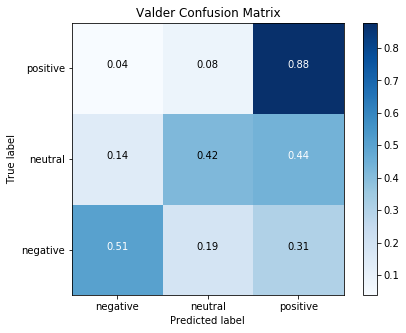

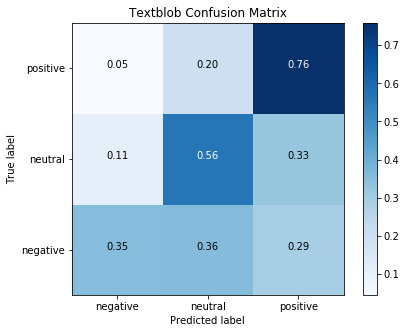

In [26]:
# CONFUSION MATRIX PLOT
def plot_confusion_matrix(method, cm, classes, normalize=True, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylim([-0.5, 2.5])
    plt.title(method + " Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


methods = ["Valder", "Textblob"]

for method in methods:
  target = tweets["airline_sentiment"]
  predicted_TextBlob = tweets["polarity_"+ method +"_string"]

  class_names = unique_labels(target, predicted_TextBlob)

  # Computing the confusion matrix
  cnf_matrix = confusion_matrix(target, predicted_TextBlob)
  np.set_printoptions(precision=2)

  # Ploting non-normalized confusion matrix
  fig, ax = plt.subplots(figsize=(7,5))
  plot_confusion_matrix(method, cnf_matrix, classes=class_names)
  fig.show()


Text(0.5, 0, 'TEXTBLOB Polarity')

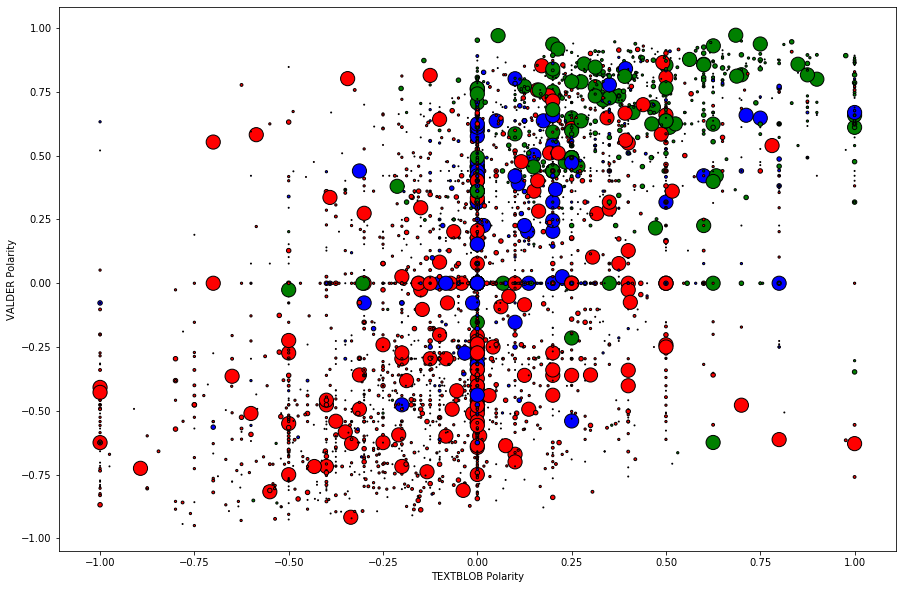

In [48]:
# Another way to visualize the error predicted by both methods, size dots = # followers
X = tweets["polarity_Textblob"]
y = tweets["polarity_Valder"]
followers = tweets["Followers"]
s = []
for t in followers:
  if t < 100:
    s.append(1)
  elif t < 500:
    s.append(5)
  elif t < 1500:
    s.append(8)
  elif t < 5000:
    s.append(20)
  else:
    s.append(200)


def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='negative':
            cols.append('red')
        elif l=='neutral':
            cols.append('blue')
        else:
            cols.append('green')
    return cols

colors = pltcolor(tweets["airline_sentiment"])

plt.figure(figsize=(15,10))
plt.scatter(X[0:5000], y[0:5000], c = colors[0:5000], edgecolors='k', s = s[0:5000])
plt.ylabel('VALDER Polarity')
plt.xlabel('TEXTBLOB Polarity')

As we saw in the confusion matrix, the accuracy of TextBlob and Valder is not really good. Now we want to focus with those tweets where the actual value is positive but TextBlob classified as negative:

> **Green dots in the previous graph ubicated in x < 0**

**Spoiler!** TextBlob does not distinguish sarcasm or irony and have serious problems when have to classify *ambiguous words* such as "killed".

*Other examples:*
* less painful
* obsessed with
* it was absurd
* freaked me out
* fixed the broken ramp
* "*We left iPad in a seat pocket.  Filed lost item report. Received it exactly 1 week Late Flightr.  Is that a record?  #unbelievable*"
---
However, this is not a significant problem since represents de 1% of the total tweets...

In [0]:
pred_TBlob = tweets["polarity_Textblob"]
pred_Vlder = tweets["polarity_Valder"]
act_sent = tweets[["airline_sentiment","text"]]

In [29]:
# Actual value: positive - Predicted value: negative -> 1% of total decisions
apos_pneg = []

for i in range(len(pred_Vlder)):
  if pred_Vlder[i] < 0 and act_sent.iloc[i,0] == "positive":
    apos_pneg.append(act_sent.iloc[i,1]) 

for i in range(0,10):
  print(apos_pneg[i])


@virginamerica Well, I didn't…but NOW I DO! :-D
@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo
@VirginAmerica come back to #PHL already. We need you to take us out of this horrible cold. #pleasecomeback http://t.co/gLXFwP6nQH
@VirginAmerica twitter team. you guys killed it for rescheduling me asap. thank you!
@united he has no priority and Iove it
@united it's kinda funny. No worries.
@united just confirmed a seat! Crisis averted! Beers won't be missed now
@united thanks for the effort. I can get the earliest. Though I will make a complaint for a refund as I am losing one business day tomorrow
@United Wanted to compliment ur phone agent Jeanette for reFlight Booking Problems RDU to SEA thru SFO after connecting flight thru EWR was Cancelled Flightled.
@united Denver baggage handlers you totally impressed us today. Our lungs barely made the run to connect but our bags had no problem! #DEN


Now we want to focus with those tweets where the actual value is negative but TextBlob classified as positive:

> **Red dots in the previous graph ubicated in x > 0** 

This is an important issue since 18% of total decisions using either the Textblob or Valder are made wrongly.

In [30]:
# Actual value: negative - Predicted value: positive -> 18% of total decisions
aneg_ppos = []

for i in range(len(pred_Vlder)):
  if pred_Vlder[i] > 0 and act_sent.iloc[i,0] == "negative":
    aneg_ppos.append(act_sent.iloc[i,1]) 

for i in range(0,10):
  print(aneg_ppos[i])

@VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!
@united Usually an issue with Express our of SFO. Positive note: Mainline p.s. was enjoyable.
@VirginAmerica soooo are you guys going to leave the seatbelt light on all flight? You can barely call this turbulence :-)
@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!
@VirginAmerica Your chat support is not working on your site: http://t.co/vhp2GtDWPk
@VirginAmerica you're the best!! Whenever I (begrudgingly) use any other airline I'm delayed and Late Flight :(
@VirginAmerica what is going on with customer service? Is there anyway to speak to a human asap? Thank you.
@VirginAmerica I like the TV and interesting video . Just disappointed in Cancelled Fli

$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ Predicted \ \ Value $$
$$ Actual \ \ Value \  \begin{pmatrix}
a_{pos}\_p_{pos} & a_{pos}\_p_{neu} & a_{pos}\_p_{neg}\\
a_{neu}\_p_{pos} & a_{neu}\_p_{neu} & a_{neu}\_p_{neg}\\
a_{neg}\_p_{pos} & a_{neg}\_p_{neu} & a_{neg}\_p_{neg}\\
\end{pmatrix}$$





In [0]:
# Storing the incorrect predicted tweets

# Actual value: neutral - Predicted value: positive
aneu_ppos = []
for i in range(len(pred_Vlder)):
  if pred_Vlder[i] > 0 and act_sent.iloc[i,0] == "neutral":
    aneu_ppos.append(act_sent.iloc[i,1]) 

# Actual value: negative - Predicted value: neutral
aneg_pneu = []
for i in range(len(pred_Vlder)):
  if pred_Vlder[i] == 0 and act_sent.iloc[i,0] == "negative":
    aneg_pneu.append(act_sent.iloc[i,1])

# Actual value: positive - Predicted value: neutral
apos_pneu = []
for i in range(len(pred_Vlder)):
  if pred_Vlder[i] == 0 and act_sent.iloc[i,0] == "positive":
    apos_pneu.append(act_sent.iloc[i,1])

# Actual value: neutral - Predicted value: negative
apos_pneu = []
for i in range(len(pred_Vlder)):
  if pred_Vlder[i] < 0 and act_sent.iloc[i,0] == "neutral":
    apos_pneu.append(act_sent.iloc[i,1])

In [32]:
def incorrect_predicted_tweets(actual_sentiment, predicted_sentiment): # NOT IMPLEMENTED
  df = []
  column_name = "a" + actual_sentiment[0:3] + "_" + "p" + predicted_sentiment[0:3]
  if predicted_sentiment == "positive":
    sign = ">"
  if predicted_sentiment == "neutral":
    sign = "=="
  else:   
    sign = "<"
      
  for i in range(len(pred_Vlder)):
    if pred_Vlder[i] sign 0 and act_sent.iloc[i,0] == actual_sentiment:
      df[column_name].append(act_sent.iloc[i,1])

print(incorrect_predicted_tweets("positive", "positive"))

SyntaxError: ignored

As we can observed in the printed tweeets from above, the TextBlob and Valder methods don't weight properly the words in the tweet. Let's take an example to understand what really is happening:

In [0]:
tweets_sample = ("moved my seat with no notice. Better seat is cabin select not behind the row I selected👎 #DISAPPOINTED",
                 "moved my seat with no notice. Better seat is cabin select not behind the row I selected👎 # DISAPPOINTED", 
                 "why can't we book seats on your flights when we buy them or even during check in? Creates so much anxiety! #frustrated",
                 "why can't we book seats on your flights when we buy them or even during check in? Creates so much anxiety! # frustrated",
                 "i need to change my flight thats scheduled in 9 hours and 120 min wait time on phone. Im calling intern. Help!!") 
print(sentiment_analysis(tweets_sample))

The columns we need to focus are:
-  `polarity` which is the sentiment analysis using Textblob.
-  `compound` which is the sentiment analysis using Valder.

The lecturer will have noticed that when we have a *hastag* both methods do not take into account the word - i.e. *disappointed* and *frustrated*

This are one of the multiple problems that we want to solve. For that, in the next section we will try to apply the **N-GRAMS** approach. To do that, we need, first of all to tokenize the whole bunch of tweets.

---
TO DO: 
- Split hastags, specially the # with the word
- Intesify words: joke, help, wait, delayed, luggage, suitcase, turbulence

### 5.2) Filter tweets function

The function **`filter_tweets`** allows the user to *tokenize* the tweet removing the *noise*:

**Tokens removed**:
*   Stop words
*   Punctuation
*   Tokens with less than 3 characters
*   Tokens containing a non alphabet character (i.e. "/", "@", etc.)
*   Empty tokens (not implemented)

Then the trailing whitespaces are removed from the token using `strip()` and finally is converted to a lowercase word using `lower()`. If after removing the not desired tokens the `filtered_tweet` is empty, we do not include it into the `list_filtered_tweets`.

**Arguments**: 
*   `list_tweets`: array containing the tweets. 
*   `number_observations`: how many observations we want to treat (it will be removed in the future but now is usefull)

In [0]:
def filter_tweets(list_tweets):  # TO DO: zip with account_name
    list_filtered_tweets = []

    for tweet in list_tweets[:len(list_tweets)]:
        filtered_tweet = []
        sentence = English()(tweet)

        for word in sentence:
            if len(word) > 2 and not word.is_stop and word.is_alpha:
                filtered_tweet.append(word.string.strip())
        
        #if len(filtered_tweet) != 0:
        list_filtered_tweets.append(filtered_tweet)
            
    return list_filtered_tweets

Here an example where the first 200 tweets from the dataframe `tweets` are filtered.


In [0]:
filter_tweets_sample = filter_tweets(list(tweets["text"][0:200]))
for tweet_filtered in filter_tweets_sample[0:10]:
  print(tweet_filtered)

Having saw that now we want to increase the accuracy of TextBlob and Valder using the N-GRAMS. The **`ngrams`** function compute `bigrams = 2-grams` and `trigrams = 3-grams`.

In [0]:
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams + trigrams

Here an example with the apos_pneg tweets. We'll see that we improve 33% from our previous rate we had before.

In [0]:
# Before computing the ngrams function we need to tockenized the tweet
apos_pneg_tockenized = filter_tweets(apos_pneg)
apos_pneg_ngrams = []
for tokens in apos_pneg_tockenized:
  apos_pneg_ngrams.append(ngrams(tokens))

In [0]:
# Then we join all the ngrams tockens as 1 string format
apos_pneg_ngrams2 = []
for tokens in apos_pneg_ngrams:
    apos_pneg_ngrams2.append(' '.join(tokens))

for tweet in apos_pneg_ngrams2[0:10]:
  print(tweet)

In [0]:
# Finally we compute the sentiment_analysis using the string created before
table = sentiment_analysis(apos_pneg_ngrams2)
ratio_improved = sum(table["compound"] > 0)/len(table["compound"])
print("Thanks to N_GRAMS we reclassifies {:.2%}".format(ratio_improved) + " of the total apos_pneg_ngrams well")

Now with the whole data set (by the moment, we take just some thousands of tweets..)

In [0]:
# For the WHOLE tweets
# 1) Tokenize the tweets
tweets_tockenized = filter_tweets(tweets["text"][0:4000])

# 2) Computing the ngrams function
tweets_tockenized2 = []
for tokens in tweets_tockenized:
  tweets_tockenized2.append(ngrams(tokens))

# 3) Join the ngrams tokens
tweets_tockenized3 = []
for tokens in tweets_tockenized2:
    tweets_tockenized3.append(' '.join(tokens))

# 4) Computing the sentiment analysis of the joined ngrams tokens
sentiment_table2 = sentiment_analysis(tweets_tockenized3)
tweets["sentiment_ngrams_Valder"] = sentiment_table2["compound"]
tweets["sentiment_ngrams_Textblob"] = sentiment_table2["polarity"]


ratio_improved = sum(sentiment_table2["compound"] > 0)/len(sentiment_table2["compound"])
print("Thanks to N_GRAMS we classify {:.2%}".format(ratio_improved) + " of the total tweets well")


In [0]:
X = tweets["polarity_Textblob"]
y = tweets["polarity_Valder"]

colors = pltcolor(tweets["airline_sentiment"])

plt.figure(figsize=(15,10))
plt.scatter(X[0:4000], y[0:4000], c = colors[0:4000], edgecolors='k', s = 30)
plt.ylabel('VALDER Polarity')
plt.xlabel('TEXTBLOB Polarity')

### 5.3) Search group function

The function **`search_group_classes`** allows the user to classify tweets by passangers classes:

**Context**:
From a business perspective, the company needs to prioritize which customer needs to be replied to firstly. The idea, is to create several classes and then sort based on priority. In the ideal world, this priority will be based on ticket price but this information cannot be inferred.

- The first approach is to classify into 2 classes: **business class** and **not business class** only using the tweet text (i.e.: type of words in the tweet, orthography, etc.)

- The second approach is to figure out what is the scope of the tweet. For instance, if the account is verified, or the complaint is made by a very popular account (with a lot of followers) the complaint needs to be dealt quickly. *(NOT IMPLEMENTED)*

**Arguments**: 
*   `airline_sentiment`: determines the sentiment analysis we want to work with. Possible values: `('positive', 'negative', 'neutral')` 
*   `list_words`: words that define the group class, i.e.`("business class|first class|priority|preference")`

In [0]:
def search_group_classes(airline_sentiment, list_words):
    df_neg = (tweets[tweets['airline_sentiment'] == airline_sentiment])
    list_tweets = df_neg["text"]

    output = []
    for tweet in list_tweets:
        if re.findall(list_words, tweet):
            output.append(tweet)

    return output

Here we want to gathered the **business class tweets** from the dataset `tweets`.

In [0]:
business_class = ("business class|first class|priority|preference") # TO DO: store it in the tweets dataframe
business_class_tweets = search_group_classes("negative", business_class)
for bc_tweet in business_class_tweets[0:10]:
    print(bc_tweet)

## VADER
**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner is another popular rule-based library for sentiment analysis. Like TextBlob, it uses a sentiment lexicon that contains intensity measures for each word based on human-annotated labels. A key difference however, is that VADER was designed with a **focus on social media texts**. This means that it puts a lot of emphasis on rules that capture the essence of text typically seen on social media — for example, **short sentences with emojis**, **repetitive vocabulary** and copious use of **punctuation** (such as exclamation marks). Below are some examples of the sentiment intensity scores output by VADER.

## Understanding the polarity scores with TextBlob and Valder

In [0]:
valder = SentimentIntensityAnalyzer()
print(valder.polarity_scores("This was the best idea I've had in a long time."))
print(valder.polarity_scores("best idea time."))
print(valder.polarity_scores("This was the BEST idea I've had in a long time."))
print(valder.polarity_scores("This was the BEST idea I've had in a long time!"))
print(valder.polarity_scores("This was the BEST idea I've had in a long time!!!"))
print(valder.polarity_scores("This was the BEST, BEST idea I've had in a long time!!! :D :D"))
print(valder.polarity_scores("This was the WORST, WORST idea I've had in a long time!!! :( :("))

In [0]:
print(TextBlob("This was the best idea I've had in a long time.").sentiment)
print(TextBlob("best idea time.").sentiment)
print(TextBlob("This was the BEST idea I've had in a long time.").sentiment)
print(TextBlob("This was the BEST idea I've had in a long time!").sentiment)
print(TextBlob("This was the BEST idea I've had in a long time!!!").sentiment)
print(TextBlob("This was the BEST, BEST idea I've had in a long time!!! :D :D").sentiment)
print(TextBlob("This was the WORST, WORST idea I've had in a long time!!! :( :(").sentiment)


*TO DO: implement N-gramms*

FOREST